In [11]:
import pandas as pd
import seaborn as sns

from itertools import chain
from pathlib import Path

import re

import os
os.environ["DB_PATH"]='../../../db.json'
from neuroblu_postgres.databaseIO import pgIO

from nltk.tokenize import sent_tokenize

from tqdm.notebook import tqdm

# Reading from CDM - repsonse table

In [4]:
# about 1min for 11Million rows
responSectionTextsDfPath = Path('responSectionTexts.csv')

if not responSectionTextsDfPath.exists():
    responSectionTexts = pgIO.getDataIterator(
        query=f'''
        SELECT 
            response.trt_plan_id AS patient_encounter_id, 
            response.source_id AS header, 
            response.response AS section
        FROM thc.response
        ; 
        ''',
        dbName='NLP_CDM',
        chunks=10000,
    )
    
    alldata = chain(*responSectionTexts)

    responSectionTextsDf = pd.DataFrame(
        alldata,
        columns=['patient_encounter_id','header', 'section'],
    )
    responSectionTextsDf.to_csv(
        responSectionTextsDfPath,
        index=False
    )
else:
    responSectionTextsDf = pd.read_csv(
        responSectionTextsDfPath,
    )

In [7]:
display(responSectionTextsDf.head())
display(responSectionTextsDf.shape)
display(responSectionTextsDf.columns)

,patient_encounter_id,header,section
0,1111796,2188,none
1,942804,3350,Auditory hallucinations have stopped. Denies b...
2,942804,24876,continue \r\nWelbutrin XL 300 mg in the morini...
3,942804,22507,Expressed concern about inability to work beca...
4,942804,0,Final Approved [DATE_1] 03:41PM by [NAME_1]\r\...


(666101, 3)

Index(['patient_encounter_id', 'header', 'section'], dtype='object')

<AxesSubplot:xlabel='section'>

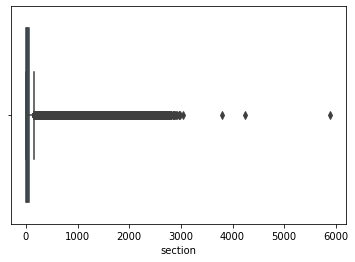

In [8]:
sectionLength = responSectionTextsDf.section.str.count(' ')
sns.boxplot(x=sectionLength)

The default value of regex will change from True to False in a future version.
The default value of regex will change from True to False in a future version.
The default value of regex will change from True to False in a future version.


,patient_encounter_id,header,section
0,1111796,2188,none
1,942804,3350,Auditory hallucinations have stopped. Denies b...
2,942804,24876,continue Welbutrin XL 300 mg in the morining H...
3,942804,22507,Expressed concern about inability to work beca...
4,942804,0,Final Approved [DATE_1] 03:41PM by [NAME_1] [D...


<AxesSubplot:xlabel='section'>

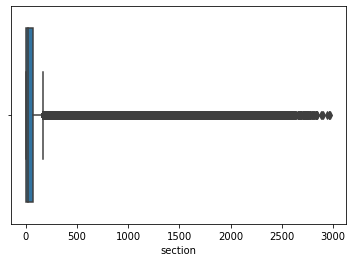

In [9]:
responSectionTextsDf['section']=responSectionTextsDf.section.str.replace(
    '\s{2,}', ' '
)

responSectionTextsDf['section']=responSectionTextsDf.section.str.replace(
    '_{3,}', ' \r\n '
)

responSectionTextsDf['section']=responSectionTextsDf.section.str.replace(
    '={3,}', ' \r\n '
)

responSectionTextsDf['section']=responSectionTextsDf.section.str.replace(
    '-{3,}', ' \r\n '
)

responSectionTextsDf['section']=responSectionTextsDf.section.str.replace(
    ';', ' \r\n '
)

responSectionTextsDf['section']=responSectionTextsDf.section.str.replace(
    '\r\n', ' \r\n '
)

display(responSectionTextsDf.head())

sectionLength = responSectionTextsDf.section.str.count(' ')
sns.boxplot(x=sectionLength)

# Quick Process using nltk

0it [00:00, ?it/s]

  0%|          | 0/666101 [00:00<?, ?it/s]

,patient_encounter_id,header,section,nltk_break,nltk_break_order
0,1111796,2188,none,none,1
1,942804,3350,Auditory hallucinations have stopped. Denies b...,Auditory hallucinations have stopped.,1
1,942804,3350,Auditory hallucinations have stopped. Denies b...,Denies being paranoid.,2
1,942804,3350,Auditory hallucinations have stopped. Denies b...,Hygiene and grooming have improved,3
2,942804,24876,continue Welbutrin XL 300 mg in the morining H...,continue Welbutrin XL 300 mg in the morining H...,1


(3457399, 5)

<AxesSubplot:ylabel='nltk_break'>

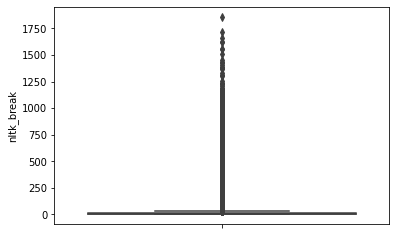

In [13]:
tqdm().pandas()

responSectionTextsDf['nltk_break']=responSectionTextsDf\
    .section.apply(str)\
    .progress_apply(sent_tokenize)
    
responSectionTextsDf = responSectionTextsDf\
    .explode('nltk_break')
    
responSectionTextsDf['nltk_break_order'] = responSectionTextsDf\
    .groupby(['patient_encounter_id', 'header'])\
    .nltk_break\
    .transform(lambda series: range(1,len(series)+1))
    
display(responSectionTextsDf.head())
display(responSectionTextsDf.shape)

sns.boxplot(
    y=responSectionTextsDf.nltk_break.str.count(' ')
)

In [15]:
(responSectionTextsDf.nltk_break.str.count(' ') > 200).sum()

5010

In [16]:
responSectionTextsDf.to_csv(
    'responSectionTextsDf_nltk_break.csv',
    index=False
)